# HDFS Dataset - Exploratory Data Analysis
## Day 29: Deep Dive into Pre-processed HDFS Data

**Dataset Source:** LogHub - HDFS_v1  
**Citation:** Wei Xu et al. (SOSP 2009), Jieming Zhu et al. (ISSRE 2023)

---

### Overview
This notebook explores the pre-processed HDFS dataset which includes:
- 575,061 log sequences (grouped by BlockId)
- 29 unique log templates (extracted via Drain)
- Binary labels (Normal/Anomaly)
- ~11.2M raw log entries

### Objectives
1. Understand data structure and format
2. Analyze sequence characteristics
3. Compare normal vs anomaly patterns
4. Generate statistics for thesis Chapter 5.1

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create figures directory
import os
os.makedirs('figures', exist_ok=True)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


---
## 1. Data Loading
Load all preprocessed files and understand their structure.

In [6]:
# Define paths
DATA_DIR = 'data/hdfs/preprocessed'

In [8]:
# 1.1 Load Templates
templates_df = pd.read_csv(f'{DATA_DIR}/HDFS.log_templates.csv')
print(f"\n Templates (Total: {len(templates_df)})")
print("-" * 60)
print(templates_df.head())
print("\nTemplates loaded")


 Templates (Total: 29)
------------------------------------------------------------
  EventId                           EventTemplate
0      E1  [*]Adding an already existing block[*]
1      E2        [*]Verification succeeded for[*]
2      E3                 [*]Served block[*]to[*]
3      E4  [*]Got exception while serving[*]to[*]
4      E5    [*]Receiving block[*]src:[*]dest:[*]

Templates loaded


In [9]:
# 1.2 Load Labels
labels_df = pd.read_csv(f'{DATA_DIR}/anomaly_label.csv')
print(f"\nLabels (Total blocks: {len(labels_df):,})")
print("-" * 60)
print(labels_df.head())
print(f"\nLabel Distribution:")
label_counts = labels_df['Label'].value_counts()
print(label_counts)
print(f"\nAnomaly Rate: {(labels_df['Label']=='Anomaly').sum() / len(labels_df) * 100:.2f}%")
print("\nLabels loaded")


Labels (Total blocks: 575,061)
------------------------------------------------------------
                    BlockId    Label
0  blk_-1608999687919862906   Normal
1   blk_7503483334202473044   Normal
2  blk_-3544583377289625738  Anomaly
3  blk_-9073992586687739851   Normal
4   blk_7854771516489510256   Normal

Label Distribution:
Label
Normal     558223
Anomaly     16838
Name: count, dtype: int64

Anomaly Rate: 2.93%

Labels loaded


In [10]:
# 1.3 Load Event Traces (sample first)
print("\n Event Traces (loading sample of 10,000 rows)")
print("-" * 60)
traces_sample = pd.read_csv(f'{DATA_DIR}/Event_traces.csv', nrows=10000)
print(f"Columns: {traces_sample.columns.tolist()}")
print(f"\nSample rows:")
print(traces_sample.head())
print("\n✓ Event traces (sample) loaded")


 Event Traces (loading sample of 10,000 rows)
------------------------------------------------------------
Columns: ['BlockId', 'Label', 'Type', 'Features', 'TimeInterval', 'Latency']

Sample rows:
                    BlockId    Label  Type  \
0  blk_-1608999687919862906  Success   NaN   
1   blk_7503483334202473044  Success   NaN   
2  blk_-3544583377289625738     Fail  21.0   
3  blk_-9073992586687739851  Success   NaN   
4   blk_7854771516489510256  Success   NaN   

                                            Features  \
0  [E5,E22,E5,E5,E11,E11,E9,E9,E11,E9,E26,E26,E26...   
1  [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   
2  [E5,E22,E5,E5,E11,E9,E11,E9,E11,E9,E3,E26,E26,...   
3  [E5,E22,E5,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   
4  [E5,E5,E22,E5,E11,E9,E11,E9,E11,E9,E26,E26,E26...   

                                        TimeInterval  Latency  
0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     3802  
1  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...     38

In [11]:
# 1.4 Load Event Occurrence Matrix (sample first)
print("\n Event Occurrence Matrix (loading sample of 10,000 rows)")
print("-" * 60)
occurrence_sample = pd.read_csv(f'{DATA_DIR}/Event_occurrence_matrix.csv', nrows=10000)
print(f"Shape: {occurrence_sample.shape}")
print(f"Columns: {occurrence_sample.columns.tolist()}")
print(f"\nSample rows:")
print(occurrence_sample.head())
print("\n Event occurrence matrix (sample) loaded")


 Event Occurrence Matrix (loading sample of 10,000 rows)
------------------------------------------------------------
Shape: (10000, 32)
Columns: ['BlockId', 'Label', 'Type', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29']

Sample rows:
                    BlockId    Label  Type  E1  E2   E3  E4  E5  E6  E7  ...  \
0  blk_-1608999687919862906  Success   NaN   0   0  203   0  10   7   0  ...   
1   blk_7503483334202473044  Success   NaN   0   2    1   0   3   0   0  ...   
2  blk_-3544583377289625738     Fail  21.0   0   0  203   0   3   0   0  ...   
3  blk_-9073992586687739851  Success   NaN   0   3    0   0   3   0   0  ...   
4   blk_7854771516489510256  Success   NaN   0   3    1  15   3   0   0  ...   

   E20  E21  E22  E23  E24  E25  E26  E27  E28  E29  
0    0   10    1   10    0    4   10    0    0    0  
1    0    3    1    3    0 

In [13]:
# 1.5 Load NPZ data (most efficient format)
print("\n Loading NPZ format (optimized for modeling)")
print("-" * 60)
data_npz = np.load(f'{DATA_DIR}/HDFS.npz', allow_pickle=True)
sequences = data_npz['x_data']  # Event sequences
labels = data_npz['y_data']     # Labels (0=Normal, 1=Anomaly)

print(f"Sequences shape: {sequences.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nFirst 5 sequences:")
for i in range(5):
    print(f"  Seq {i}: Length={len(sequences[i])}, Label={labels[i]}, Events={sequences[i]}")
print("\n NPZ data loaded")


 Loading NPZ format (optimized for modeling)
------------------------------------------------------------
Sequences shape: (575061,)
Labels shape: (575061,)

First 5 sequences:
  Seq 0: Length=13, Label=0, Events=['E5', 'E5', 'E5', 'E22', 'E11', 'E9', 'E11', 'E11', 'E9', 'E9', 'E26', 'E26', 'E26']
  Seq 1: Length=13, Label=0, Events=['E5', 'E22', 'E5', 'E5', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E26']
  Seq 2: Length=19, Label=0, Events=['E5', 'E5', 'E5', 'E22', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E26', 'E23', 'E23', 'E23', 'E21', 'E21', 'E21']
  Seq 3: Length=28, Label=0, Events=['E22', 'E5', 'E5', 'E5', 'E26', 'E11', 'E9', 'E26', 'E26', 'E11', 'E9', 'E11', 'E9', 'E3', 'E3', 'E4', 'E3', 'E3', 'E4', 'E3', 'E3', 'E4', 'E23', 'E23', 'E23', 'E21', 'E21', 'E21']
  Seq 4: Length=13, Label=0, Events=['E5', 'E22', 'E5', 'E5', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E26']

 NPZ data loaded


---
## 2. Basic Statistics
Compute fundamental dataset statistics.

In [14]:
# 2.1 Overall Dataset Statistics
print("\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

total_blocks = len(sequences)
normal_count = (labels == 0).sum()
anomaly_count = (labels == 1).sum()
anomaly_rate = anomaly_count / total_blocks * 100

stats = {
    'Total Blocks': total_blocks,
    'Normal Blocks': normal_count,
    'Anomaly Blocks': anomaly_count,
    'Anomaly Rate (%)': f"{anomaly_rate:.2f}%",
    'Unique Templates': len(templates_df),
}

for key, value in stats.items():
    print(f"{key:.<40} {value:>15}")

# Sequence length statistics
seq_lengths = np.array([len(seq) for seq in sequences])
print(f"\n{'Sequence Length Stats':.<40}")
print(f"  Min Length:............................... {seq_lengths.min()}")
print(f"  Max Length:............................... {seq_lengths.max()}")
print(f"  Mean Length:.............................. {seq_lengths.mean():.2f}")
print(f"  Median Length:............................ {np.median(seq_lengths):.0f}")
print(f"  Std Dev:.................................. {seq_lengths.std():.2f}")


DATASET STATISTICS
Total Blocks............................          575061
Normal Blocks...........................          558223
Anomaly Blocks..........................           16838
Anomaly Rate (%)........................           2.93%
Unique Templates........................              29

Sequence Length Stats...................
  Min Length:............................... 2
  Max Length:............................... 298
  Mean Length:.............................. 19.43
  Median Length:............................ 19
  Std Dev:.................................. 5.18


In [15]:
# 2.2 Normal vs Anomaly Sequence Lengths
normal_lengths = seq_lengths[labels == 0]
anomaly_lengths = seq_lengths[labels == 1]

print("\n" + "=" * 60)
print("SEQUENCE LENGTH COMPARISON")
print("=" * 60)

comparison = pd.DataFrame({
    'Metric': ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max'],
    'Normal': [
        len(normal_lengths),
        f"{normal_lengths.mean():.2f}",
        f"{np.median(normal_lengths):.0f}",
        f"{normal_lengths.std():.2f}",
        normal_lengths.min(),
        normal_lengths.max()
    ],
    'Anomaly': [
        len(anomaly_lengths),
        f"{anomaly_lengths.mean():.2f}",
        f"{np.median(anomaly_lengths):.0f}",
        f"{anomaly_lengths.std():.2f}",
        anomaly_lengths.min(),
        anomaly_lengths.max()
    ]
})

print(comparison.to_string(index=False))


SEQUENCE LENGTH COMPARISON
 Metric Normal Anomaly
  Count 558223   16838
   Mean  19.50   17.12
 Median     19      20
Std Dev   4.78   12.41
    Min     13       2
    Max    298     284


---
## 3. Sequence Length Analysis

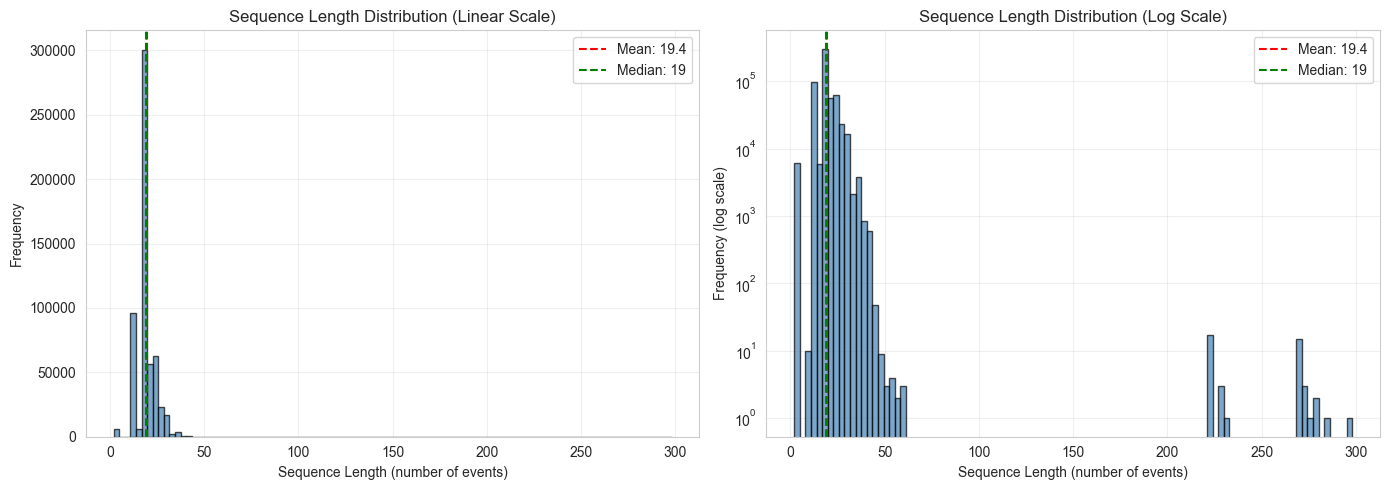

✓ Saved: figures/hdfs_sequence_length_distribution.png


In [16]:
# 3.1 Overall Sequence Length Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(seq_lengths, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Sequence Length (number of events)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Sequence Length Distribution (Linear Scale)')
axes[0].axvline(seq_lengths.mean(), color='red', linestyle='--', label=f'Mean: {seq_lengths.mean():.1f}')
axes[0].axvline(np.median(seq_lengths), color='green', linestyle='--', label=f'Median: {np.median(seq_lengths):.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].hist(seq_lengths, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Sequence Length (number of events)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Sequence Length Distribution (Log Scale)')
axes[1].set_yscale('log')
axes[1].axvline(seq_lengths.mean(), color='red', linestyle='--', label=f'Mean: {seq_lengths.mean():.1f}')
axes[1].axvline(np.median(seq_lengths), color='green', linestyle='--', label=f'Median: {np.median(seq_lengths):.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/hdfs_sequence_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figures/hdfs_sequence_length_distribution.png")

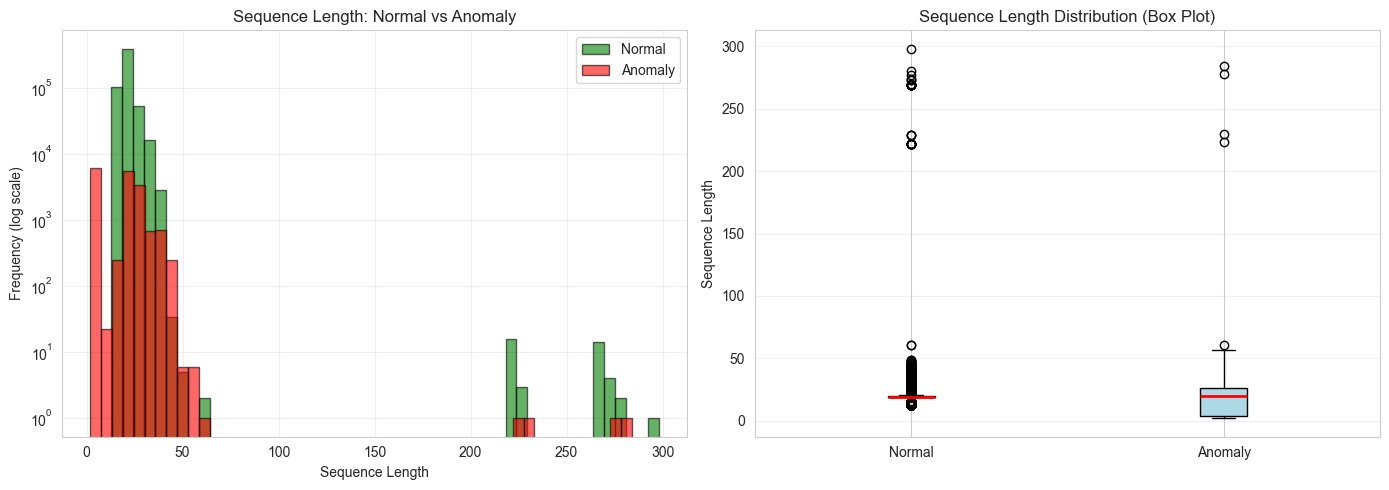

✓ Saved: figures/hdfs_normal_vs_anomaly_lengths.png


In [17]:
# 3.2 Normal vs Anomaly Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overlapping histograms
axes[0].hist(normal_lengths, bins=50, alpha=0.6, label='Normal', color='green', edgecolor='black')
axes[0].hist(anomaly_lengths, bins=50, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
axes[0].set_xlabel('Sequence Length')
axes[0].set_ylabel('Frequency (log scale)')
axes[0].set_title('Sequence Length: Normal vs Anomaly')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
box_data = [normal_lengths, anomaly_lengths]
bp = axes[1].boxplot(box_data, labels=['Normal', 'Anomaly'], patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Sequence Length')
axes[1].set_title('Sequence Length Distribution (Box Plot)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hdfs_normal_vs_anomaly_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figures/hdfs_normal_vs_anomaly_lengths.png")

---
## 4. Event Frequency Analysis

In [18]:
# 4.1 Load full occurrence matrix for event frequency analysis
print("Loading full event occurrence matrix (this may take a moment)...")
occurrence_full = pd.read_csv(f'{DATA_DIR}/Event_occurrence_matrix.csv')
print(f"✓ Loaded {len(occurrence_full):,} rows")

# Event columns (E1-E29)
event_cols = [f'E{i}' for i in range(1, 30)]

Loading full event occurrence matrix (this may take a moment)...
✓ Loaded 575,061 rows


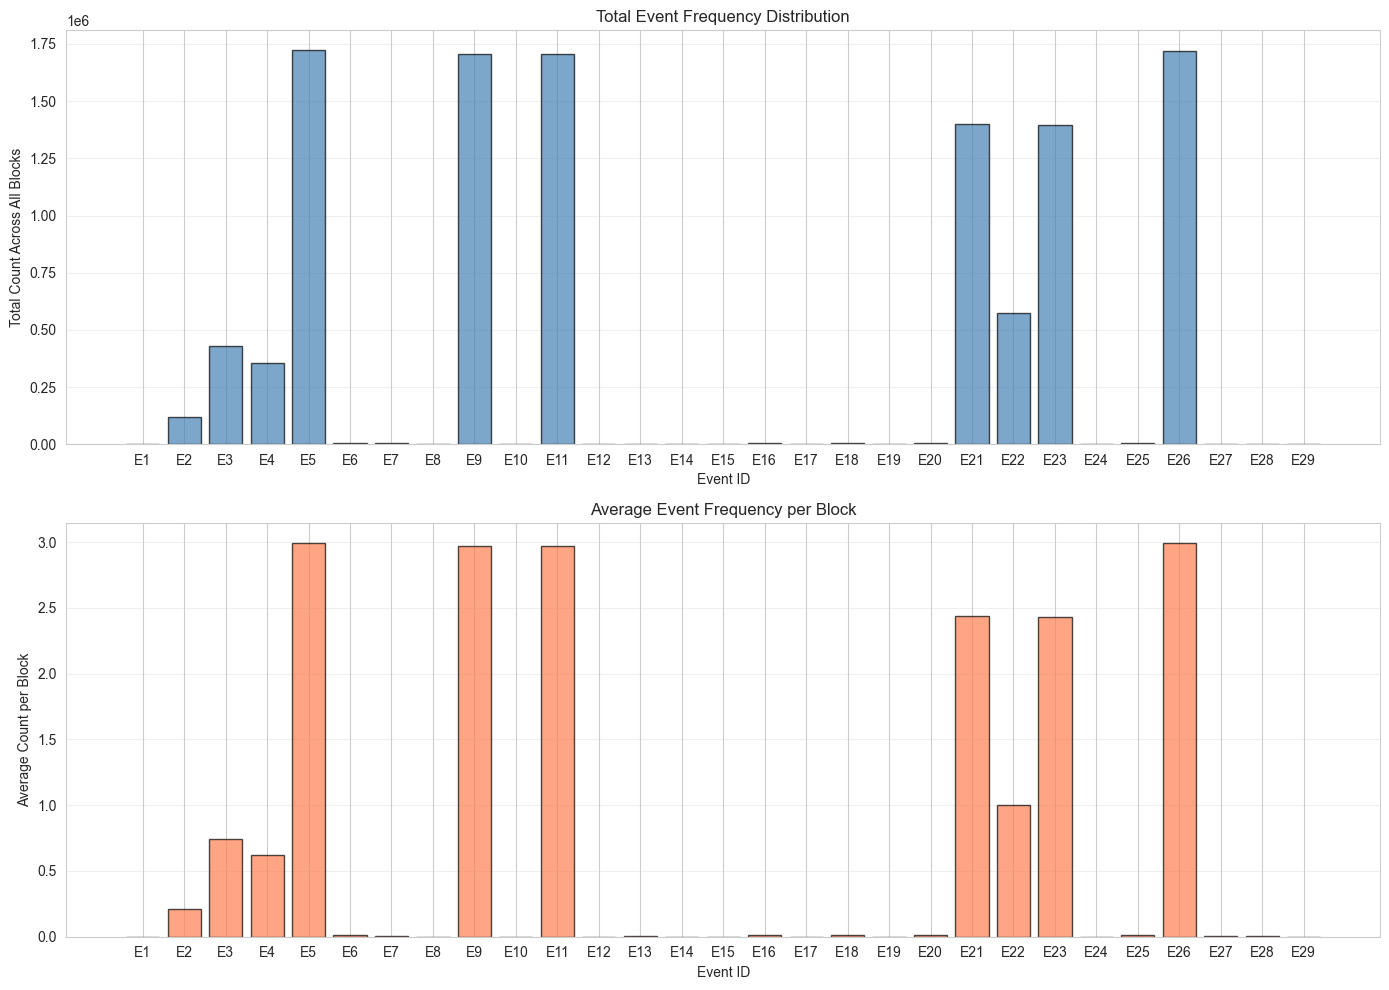

Saved: figures/hdfs_event_frequency.png


In [19]:
# 4.2 Overall event frequency
total_event_counts = occurrence_full[event_cols].sum()
avg_event_counts = occurrence_full[event_cols].mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Total counts
axes[0].bar(range(len(total_event_counts)), total_event_counts.values, 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Event ID')
axes[0].set_ylabel('Total Count Across All Blocks')
axes[0].set_title('Total Event Frequency Distribution')
axes[0].set_xticks(range(len(event_cols)))
axes[0].set_xticklabels(event_cols, rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Average counts per block
axes[1].bar(range(len(avg_event_counts)), avg_event_counts.values, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Event ID')
axes[1].set_ylabel('Average Count per Block')
axes[1].set_title('Average Event Frequency per Block')
axes[1].set_xticks(range(len(event_cols)))
axes[1].set_xticklabels(event_cols, rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hdfs_event_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/hdfs_event_frequency.png")

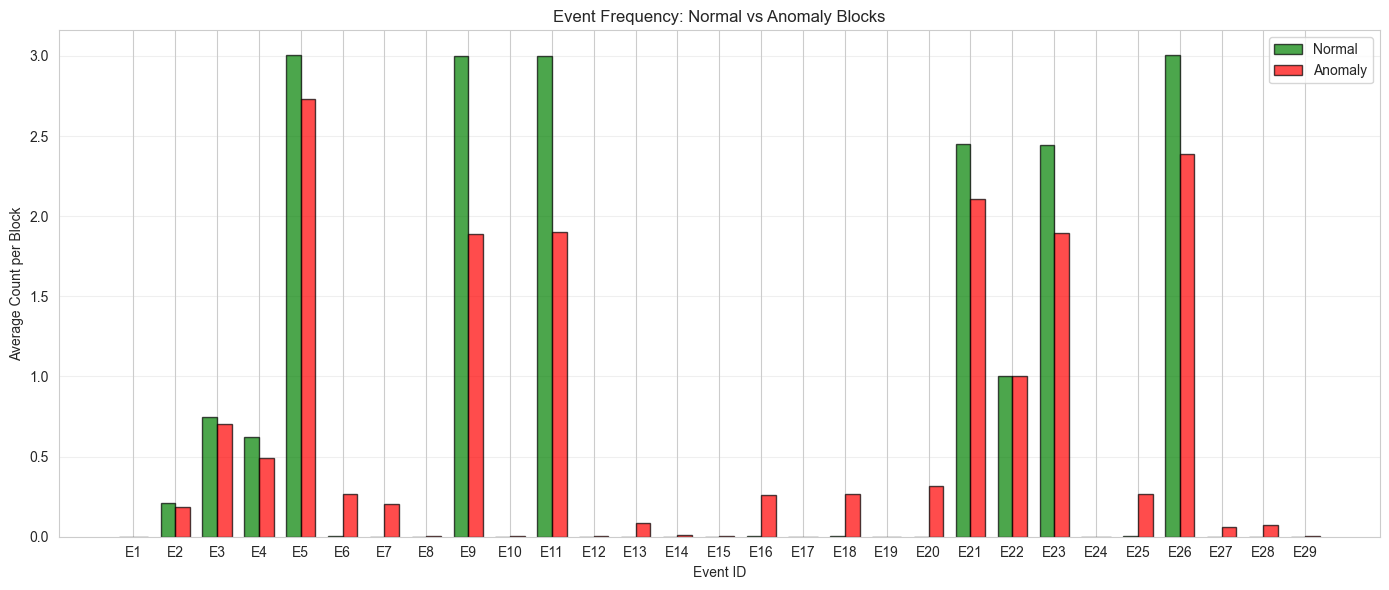

Saved: figures/hdfs_event_frequency_by_class.png


In [20]:
# 4.3 Event frequency by class (Normal vs Anomaly)
# Merge with labels
occurrence_labeled = occurrence_full.merge(labels_df, on='BlockId', how='left')

# Separate by class
normal_events = occurrence_labeled[occurrence_labeled['Label_y'] == 'Normal'][event_cols]
anomaly_events = occurrence_labeled[occurrence_labeled['Label_y'] == 'Anomaly'][event_cols]

# Calculate averages
normal_avg = normal_events.mean()
anomaly_avg = anomaly_events.mean()

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(event_cols))
width = 0.35

bars1 = ax.bar(x - width/2, normal_avg.values, width, label='Normal', 
               color='green', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, anomaly_avg.values, width, label='Anomaly', 
               color='red', alpha=0.7, edgecolor='black')

ax.set_xlabel('Event ID')
ax.set_ylabel('Average Count per Block')
ax.set_title('Event Frequency: Normal vs Anomaly Blocks')
ax.set_xticks(x)
ax.set_xticklabels(event_cols)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hdfs_event_frequency_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/hdfs_event_frequency_by_class.png")

---
## 5. Anomaly Characteristics Analysis

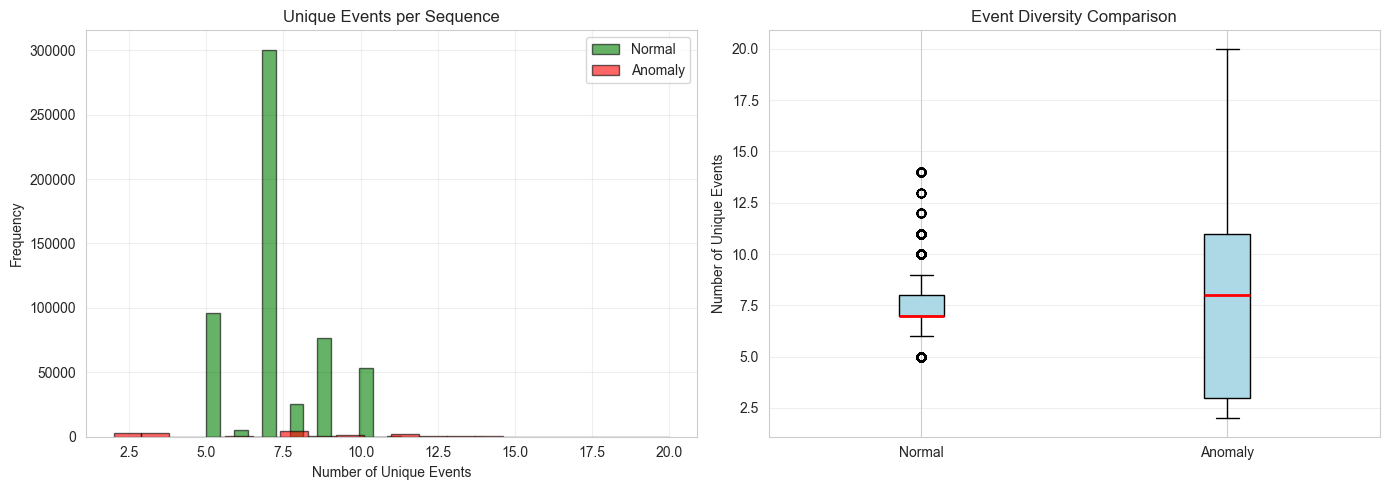

Normal - Mean unique events: 7.26
Anomaly - Mean unique events: 7.16

✓ Saved: figures/hdfs_event_diversity.png


In [21]:
# 5.1 Unique events per sequence
normal_unique = [len(set(sequences[i])) for i in range(len(sequences)) if labels[i] == 0]
anomaly_unique = [len(set(sequences[i])) for i in range(len(sequences)) if labels[i] == 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(normal_unique, bins=20, alpha=0.6, label='Normal', color='green', edgecolor='black')
axes[0].hist(anomaly_unique, bins=20, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
axes[0].set_xlabel('Number of Unique Events')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Unique Events per Sequence')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot([normal_unique, anomaly_unique], labels=['Normal', 'Anomaly'], 
                      patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Number of Unique Events')
axes[1].set_title('Event Diversity Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hdfs_event_diversity.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Normal - Mean unique events: {np.mean(normal_unique):.2f}")
print(f"Anomaly - Mean unique events: {np.mean(anomaly_unique):.2f}")
print("\n✓ Saved: figures/hdfs_event_diversity.png")

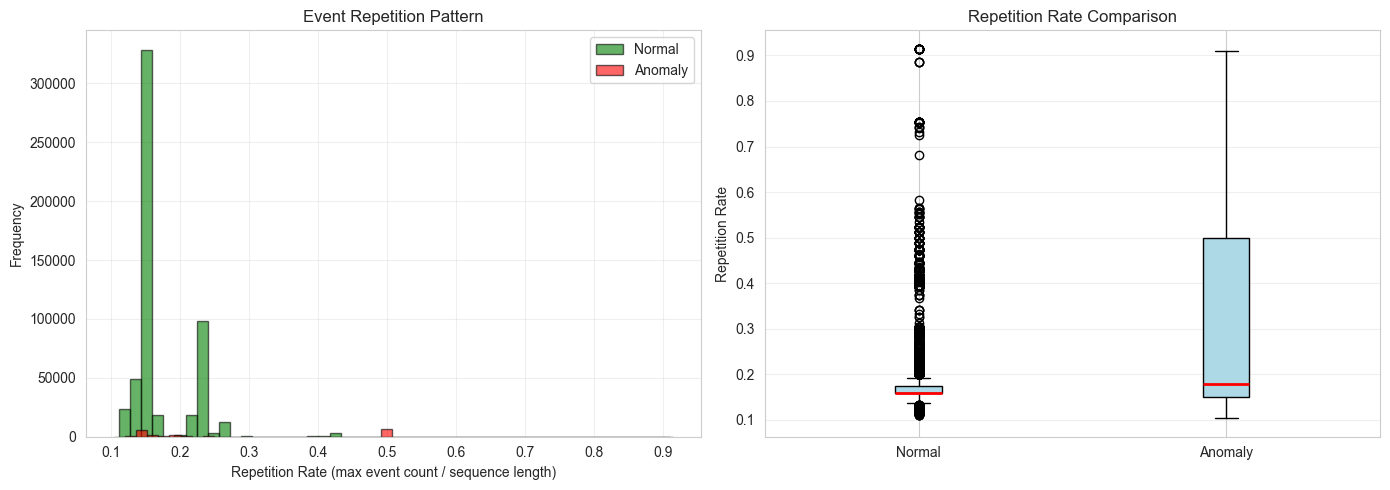

Normal - Mean repetition rate: 0.174
Anomaly - Mean repetition rate: 0.286

✓ Saved: figures/hdfs_repetition_pattern.png


In [22]:
# 5.2 Event repetition analysis
def calculate_repetition_rate(seq):
    """Calculate most frequent event repetition rate"""
    if len(seq) == 0:
        return 0
    counter = Counter(seq)
    max_count = max(counter.values())
    return max_count / len(seq)

normal_repetition = [calculate_repetition_rate(sequences[i]) for i in range(len(sequences)) if labels[i] == 0]
anomaly_repetition = [calculate_repetition_rate(sequences[i]) for i in range(len(sequences)) if labels[i] == 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(normal_repetition, bins=50, alpha=0.6, label='Normal', color='green', edgecolor='black')
axes[0].hist(anomaly_repetition, bins=50, alpha=0.6, label='Anomaly', color='red', edgecolor='black')
axes[0].set_xlabel('Repetition Rate (max event count / sequence length)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Event Repetition Pattern')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot([normal_repetition, anomaly_repetition], labels=['Normal', 'Anomaly'],
                      patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Repetition Rate')
axes[1].set_title('Repetition Rate Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hdfs_repetition_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Normal - Mean repetition rate: {np.mean(normal_repetition):.3f}")
print(f"Anomaly - Mean repetition rate: {np.mean(anomaly_repetition):.3f}")
print("\n✓ Saved: figures/hdfs_repetition_pattern.png")

---
## 6. Top Event Patterns Analysis

In [23]:
# 6.1 Most common events in normal vs anomaly sequences
normal_all_events = [event for i in range(len(sequences)) if labels[i] == 0 for event in sequences[i]]
anomaly_all_events = [event for i in range(len(sequences)) if labels[i] == 1 for event in sequences[i]]

normal_event_freq = Counter(normal_all_events)
anomaly_event_freq = Counter(anomaly_all_events)

print("\nTop 10 Most Common Events in NORMAL sequences:")
print("-" * 60)
for event, count in normal_event_freq.most_common(10):
    template = templates_df[templates_df['EventId'] == event]['EventTemplate'].values
    template_str = template[0] if len(template) > 0 else 'Unknown'
    print(f"{event}: {count:>8,} occurrences - {template_str[:60]}...")

print("\nTop 10 Most Common Events in ANOMALY sequences:")
print("-" * 60)
for event, count in anomaly_event_freq.most_common(10):
    template = templates_df[templates_df['EventId'] == event]['EventTemplate'].values
    template_str = template[0] if len(template) > 0 else 'Unknown'
    print(f"{event}: {count:>8,} occurrences - {template_str[:60]}...")


Top 10 Most Common Events in NORMAL sequences:
------------------------------------------------------------
E26: 1,679,485 occurrences - [*]BLOCK* NameSystem[*]addStoredBlock: blockMap updated:[*]i...
E5: 1,677,287 occurrences - [*]Receiving block[*]src:[*]dest:[*]...
E11: 1,674,669 occurrences - [*]PacketResponder[*]for block[*]terminating[*]...
E9: 1,674,669 occurrences - [*]Received block[*]of size[*]from[*]...
E21: 1,366,574 occurrences - [*]Deleting block[*]file[*]...
E23: 1,364,251 occurrences - [*]BLOCK* NameSystem[*]delete:[*]is added to invalidSet of[*...
E22:  558,223 occurrences - [*]BLOCK* NameSystem[*]allocateBlock:[*]...
E3:  416,884 occurrences - [*]Served block[*]to[*]...
E4:  347,948 occurrences - [*]Got exception while serving[*]to[*]...
E2:  116,907 occurrences - [*]Verification succeeded for[*]...

Top 10 Most Common Events in ANOMALY sequences:
------------------------------------------------------------
E5:   45,945 occurrences - [*]Receiving block[*]src:[*]dest:

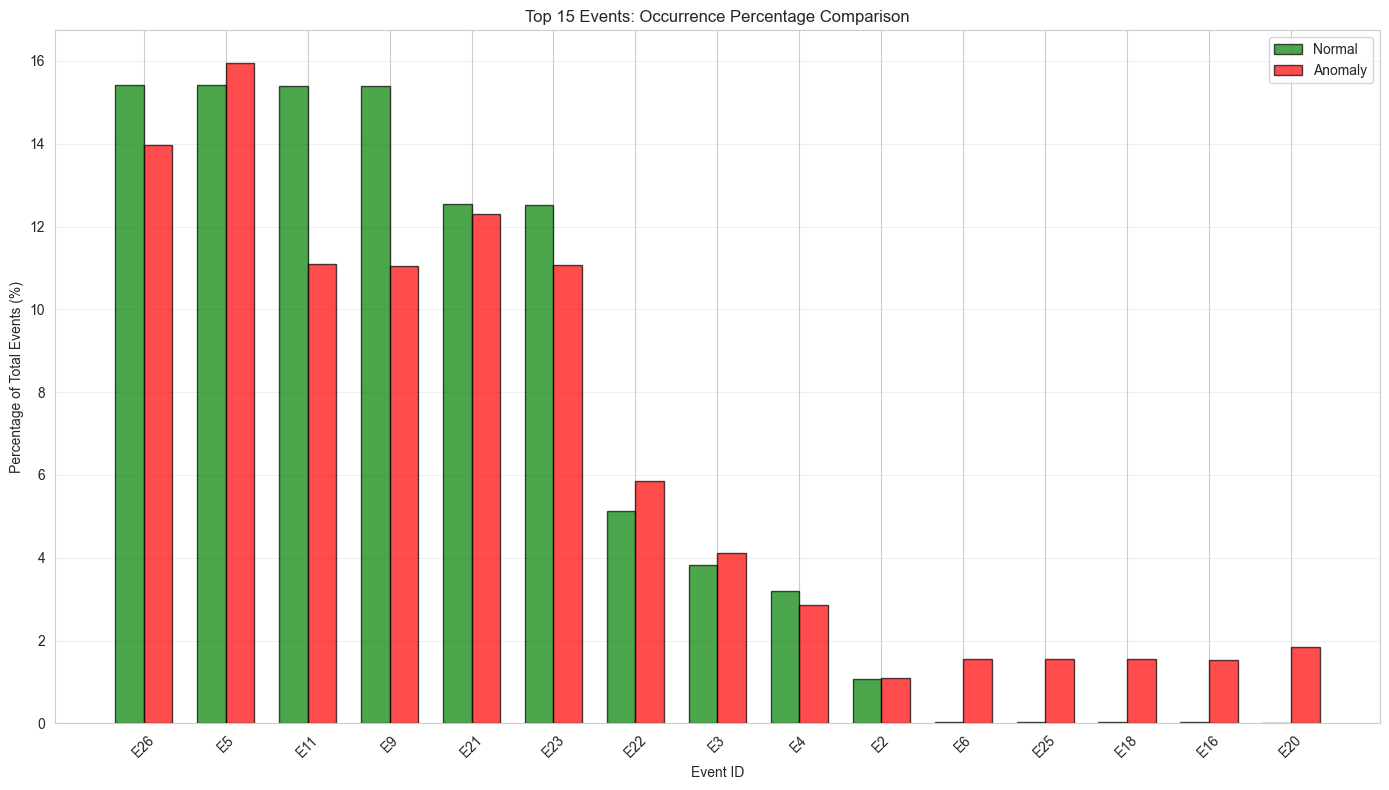

✓ Saved: figures/hdfs_top_events_comparison.png


In [24]:
# 6.2 Event occurrence percentage comparison
total_normal_events = len(normal_all_events)
total_anomaly_events = len(anomaly_all_events)

# Calculate percentages for top events
top_events = list(set(list(normal_event_freq.keys())[:15] + list(anomaly_event_freq.keys())[:15]))

normal_pct = {event: (normal_event_freq.get(event, 0) / total_normal_events * 100) for event in top_events}
anomaly_pct = {event: (anomaly_event_freq.get(event, 0) / total_anomaly_events * 100) for event in top_events}

# Sort by normal percentage
sorted_events = sorted(top_events, key=lambda x: normal_pct[x], reverse=True)[:15]

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(sorted_events))
width = 0.35

bars1 = ax.bar(x - width/2, [normal_pct[e] for e in sorted_events], width, 
               label='Normal', color='green', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, [anomaly_pct[e] for e in sorted_events], width,
               label='Anomaly', color='red', alpha=0.7, edgecolor='black')

ax.set_xlabel('Event ID')
ax.set_ylabel('Percentage of Total Events (%)')
ax.set_title('Top 15 Events: Occurrence Percentage Comparison')
ax.set_xticks(x)
ax.set_xticklabels(sorted_events, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hdfs_top_events_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: figures/hdfs_top_events_comparison.png")

---
## 7. Summary Report for Thesis

In [25]:
# 7.1 Generate comprehensive summary statistics
summary_report = f"""
{'=' * 70}
HDFS DATASET SUMMARY REPORT
For Thesis Chapter 5.1: Dataset Description
{'=' * 70}

1. DATASET OVERVIEW
   - Source: LogHub HDFS_v1
   - Total Blocks: {total_blocks:,}
   - Total Raw Log Entries: ~11.2 million
   - Unique Log Templates: {len(templates_df)}
   - Time Period: Benchmark workload execution

2. LABEL DISTRIBUTION
   - Normal Blocks: {normal_count:,} ({normal_count/total_blocks*100:.2f}%)
   - Anomaly Blocks: {anomaly_count:,} ({anomaly_rate:.2f}%)
   - Class Imbalance Ratio: 1:{normal_count/anomaly_count:.1f}

3. SEQUENCE CHARACTERISTICS
   Overall:
   - Mean Length: {seq_lengths.mean():.2f} events
   - Median Length: {np.median(seq_lengths):.0f} events
   - Min Length: {seq_lengths.min()} events
   - Max Length: {seq_lengths.max()} events
   - Std Dev: {seq_lengths.std():.2f}
   
   Normal Sequences:
   - Mean Length: {normal_lengths.mean():.2f} events
   - Median Length: {np.median(normal_lengths):.0f} events
   - Mean Unique Events: {np.mean(normal_unique):.2f}
   
   Anomaly Sequences:
   - Mean Length: {anomaly_lengths.mean():.2f} events
   - Median Length: {np.median(anomaly_lengths):.0f} events
   - Mean Unique Events: {np.mean(anomaly_unique):.2f}

4. EVENT DISTRIBUTION
   - Total Event Occurrences: {total_event_counts.sum():,}
   - Most Frequent Event: {total_event_counts.idxmax()} ({total_event_counts.max():,} times)
   - Least Frequent Event: {total_event_counts.idxmin()} ({total_event_counts.min():,} times)

5. KEY OBSERVATIONS
   - Anomaly sequences are {'shorter' if anomaly_lengths.mean() < normal_lengths.mean() else 'longer'} on average than normal sequences
   - Normal sequences have {'more' if np.mean(normal_unique) > np.mean(anomaly_unique) else 'fewer'} unique events on average
   - Class imbalance present (anomaly rate: {anomaly_rate:.2f}%)

6. PREPROCESSING STATUS
   - ✓ Log parsing completed (Drain algorithm)
   - ✓ Sequences grouped by BlockId
   - ✓ Labels assigned (manual labeling via handcrafted rules)
   - ✓ Multiple formats available (CSV, NPZ)

{'=' * 70}
"""

print(summary_report)

# Save to file
with open('figures/hdfs_dataset_summary.txt', 'w') as f:
    f.write(summary_report)

print("\nSaved: figures/hdfs_dataset_summary.txt")


HDFS DATASET SUMMARY REPORT
For Thesis Chapter 5.1: Dataset Description

1. DATASET OVERVIEW
   - Source: LogHub HDFS_v1
   - Total Blocks: 575,061
   - Total Raw Log Entries: ~11.2 million
   - Unique Log Templates: 29
   - Time Period: Benchmark workload execution

2. LABEL DISTRIBUTION
   - Normal Blocks: 558,223 (97.07%)
   - Anomaly Blocks: 16,838 (2.93%)
   - Class Imbalance Ratio: 1:33.2

3. SEQUENCE CHARACTERISTICS
   Overall:
   - Mean Length: 19.43 events
   - Median Length: 19 events
   - Min Length: 2 events
   - Max Length: 298 events
   - Std Dev: 5.18

   Normal Sequences:
   - Mean Length: 19.50 events
   - Median Length: 19 events
   - Mean Unique Events: 7.26

   Anomaly Sequences:
   - Mean Length: 17.12 events
   - Median Length: 20 events
   - Mean Unique Events: 7.16

4. EVENT DISTRIBUTION
   - Total Event Occurrences: 11,175,629
   - Most Frequent Event: E5 (1,723,232 times)
   - Least Frequent Event: E24 (4 times)

5. KEY OBSERVATIONS
   - Anomaly sequences are

In [26]:
# 7.2 Create a LaTeX-friendly table for thesis
latex_table = f"""
% HDFS Dataset Statistics Table
% For Thesis Chapter 5.1

\\begin{{table}}[h]
\\centering
\\caption{{HDFS Dataset Statistics}}
\\label{{tab:hdfs_stats}}
\\begin{{tabular}}{{lrr}}
\\toprule
\\textbf{{Metric}} & \\textbf{{Normal}} & \\textbf{{Anomaly}} \\\\
\\midrule
Number of Sequences & {normal_count:,} & {anomaly_count:,} \\\\
Mean Sequence Length & {normal_lengths.mean():.2f} & {anomaly_lengths.mean():.2f} \\\\
Median Sequence Length & {np.median(normal_lengths):.0f} & {np.median(anomaly_lengths):.0f} \\\\
Std Dev Length & {normal_lengths.std():.2f} & {anomaly_lengths.std():.2f} \\\\
Mean Unique Events & {np.mean(normal_unique):.2f} & {np.mean(anomaly_unique):.2f} \\\\
Mean Repetition Rate & {np.mean(normal_repetition):.3f} & {np.mean(anomaly_repetition):.3f} \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""

print(latex_table)

# Save to file
with open('figures/hdfs_table.tex', 'w') as f:
    f.write(latex_table)

print("\n✓ Saved: figures/hdfs_table.tex")


% HDFS Dataset Statistics Table
% For Thesis Chapter 5.1

\begin{table}[h]
\centering
\caption{HDFS Dataset Statistics}
\label{tab:hdfs_stats}
\begin{tabular}{lrr}
\toprule
\textbf{Metric} & \textbf{Normal} & \textbf{Anomaly} \\
\midrule
Number of Sequences & 558,223 & 16,838 \\
Mean Sequence Length & 19.50 & 17.12 \\
Median Sequence Length & 19 & 20 \\
Std Dev Length & 4.78 & 12.41 \\
Mean Unique Events & 7.26 & 7.16 \\
Mean Repetition Rate & 0.174 & 0.286 \\
\bottomrule
\end{tabular}
\end{table}


✓ Saved: figures/hdfs_table.tex
